In [1]:
# Mount the Google Drive Storage to this notebook

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing necessary libraries and modules
import os  # For interacting with the operating system (Colab's)
import glob  # For retrieving files matching specific patterns
import cv2  # For image processing
import numpy as np  # Handling arrays and performing numerical operations
import zipfile  # For extracting zip files
import random  # For generating random numbers
import shutil  # Module used to delete files and directories
from matplotlib import pyplot as plt  # For creating plots
from sklearn.model_selection import train_test_split  # Splitting data into training and testing sets
from sklearn.preprocessing import LabelEncoder  # Encodes categorical labels into numeric values
from keras.utils import normalize, to_categorical  # For normalizing image data and one-hot encoding
from keras.models import Model, load_model  # For defining and loading neural network models
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
# For constructing various parts of the neural network
from keras.optimizers import Adam  # An optimizer
from keras.callbacks import ModelCheckpoint, LearningRateScheduler  # For saving models and dynamically adjusting learning rates during training
from keras.metrics import MeanIoU  # For calculating the (IoU) metric
from tensorflow.keras import backend as K  # For handling tensors and applying mathematical operations directly

In [3]:
# Provide the name of your zip file that was uploaded which contains the images and their respective masks.
zip_file_name = '/content/drive/MyDrive/New.zip'  # Replace this with the actual file name

# Create a directory where the contents of the zip file will be extracted.
extract_to_dir = '/content'
os.makedirs(extract_to_dir, exist_ok=True)  # This will make sure the directory exists. If it doesn't, it creates it.

# Now, let's unzip the file.
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)  # This extracts everything in the zip file to the specified directory.

# Print confirmation that the extraction was successful.
print(f'Files extracted to {extract_to_dir}')

Files extracted to /content


In [ ]:
# This code is uesful only when we want to delete a directory (as it is not manually possible)

# Specify the path to the folder you want to delete.
folder_path = '/content/folder_name'  # Change this to the path of the folder you need to remove.

# Delete the folder and everything inside it.
shutil.rmtree(folder_path)

# Main

In [4]:
# Define the size for resizing images, if necessary
SIZE_X = 1024  # Width of the resized image
SIZE_Y = 1024  # Height of the resized image

n_classes = 5  # Total number of classes

# Create a dictionary to map class indices to their respective category names
category_mapping = {
    0: 'Unlabelled',
    1: 'Boundary',
    2: 'Land',
    3: 'Poles',
    4: 'Solar_Panels'
}

In [5]:
# Initialize an empty list to hold training images
train_images = []

# Retrieve all image paths from the specified directory and sort them alphabetically
image_paths = sorted(glob.glob("/content/New/Images/*.JPG"))

image_paths = image_paths[:]  # Could add [0:50] to strictly limit it to the first 50 images

# Loop through each image path to process the image
for img_path in image_paths:
    img = cv2.imread(img_path, 0)  # Read the image in grayscale mode (0 means grayscale)
    img = cv2.resize(img, (SIZE_Y, SIZE_X))  # Resize the image to the specified dimensions (1024x1024)
    train_images.append(img)  # Add the resized image to the list of training images

# Convert the list of images into a numpy array for further processing, such as model training
train_images = np.array(train_images)

# Duplicate the image data 3 (can change based on dataset size) times
train_images = np.concatenate([train_images] * 3, axis=0)

In [6]:
# Load and process image masks for training segmentation models
# Retrieve, resize, and prepare mask data for machine learning
# Duplicate the dataset for enhanced robustness or augmentation


# Initialize an empty list to store the mask/label data for training
train_masks = []

# Retrieve all mask paths from the specified directory and sort them alphabetically
mask_paths = sorted(glob.glob("/content/New/Masks/*.png"))

mask_paths = mask_paths[:]  # Could add [0:50] to strictly limit it to the first 50 masks

# Loop through each mask path to process the mask
for mask_path in mask_paths:
    mask = cv2.imread(mask_path, 0)  # Read the mask in grayscale mode (0 means grayscale)
    # Resize the mask with nearest neighbor interpolation to preserve label values
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)
    train_masks.append(mask)  # Add the resized mask to the list of training masks

# Convert the list of masks into a numpy array for machine learning purposes, such as model training
train_masks = np.array(train_masks)

# Duplicate the masks data 3 (can change based on dataset size) times
train_masks = np.concatenate([train_masks] * 3, axis=0)

In [7]:
# Verify the shape of the image and mask arrays after processing
# These checks help ensure that the data has been correctly resized, concatenated, and prepared
# The dimensions of both arrays should align, ensuring that each image has a corresponding mask for training

print(train_images.shape)  # Should match the number of images and their resized dimensions
print(train_masks.shape)  # Should have the same number of masks as images, with the same dimensions

(72, 1024, 1024)
(72, 1024, 1024)


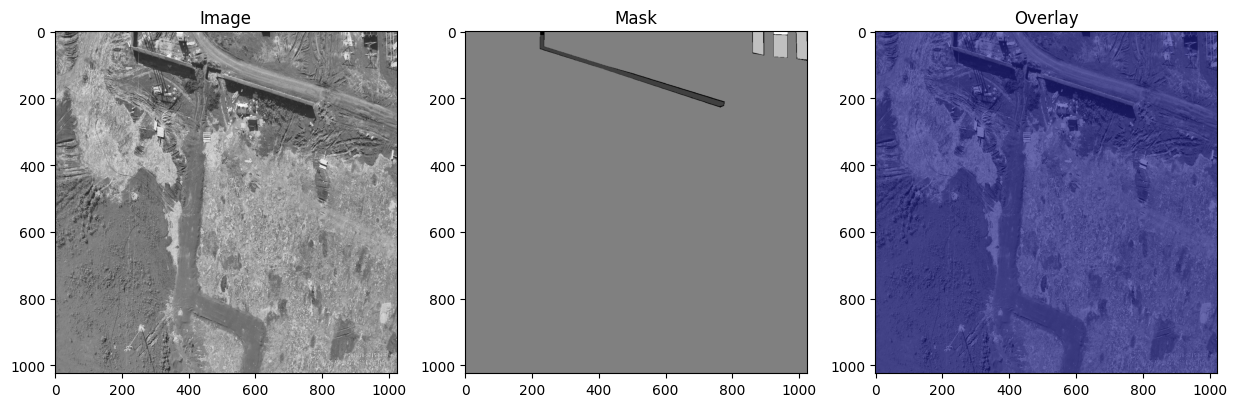

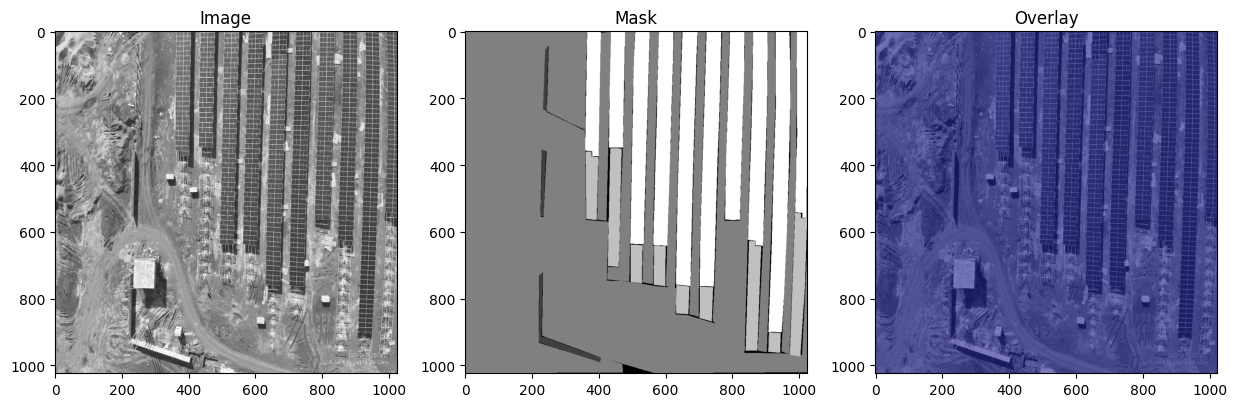

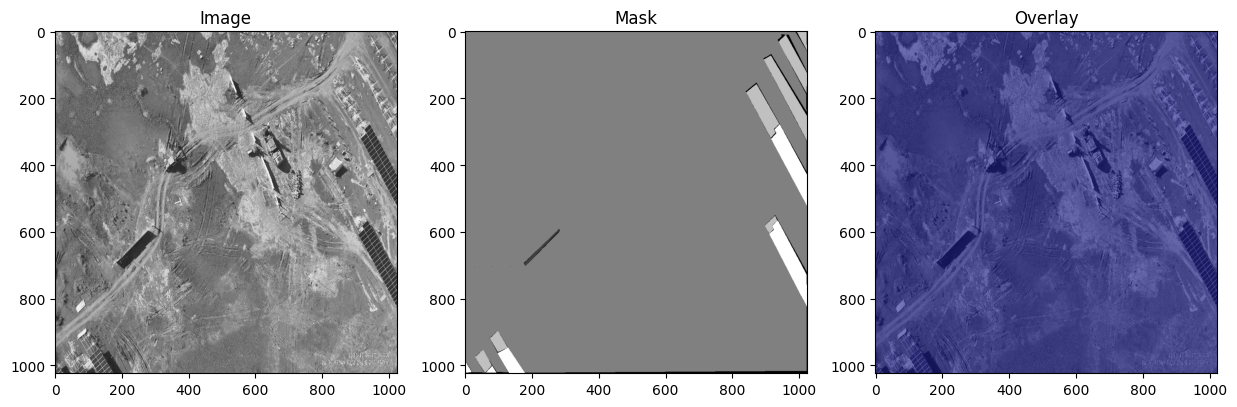

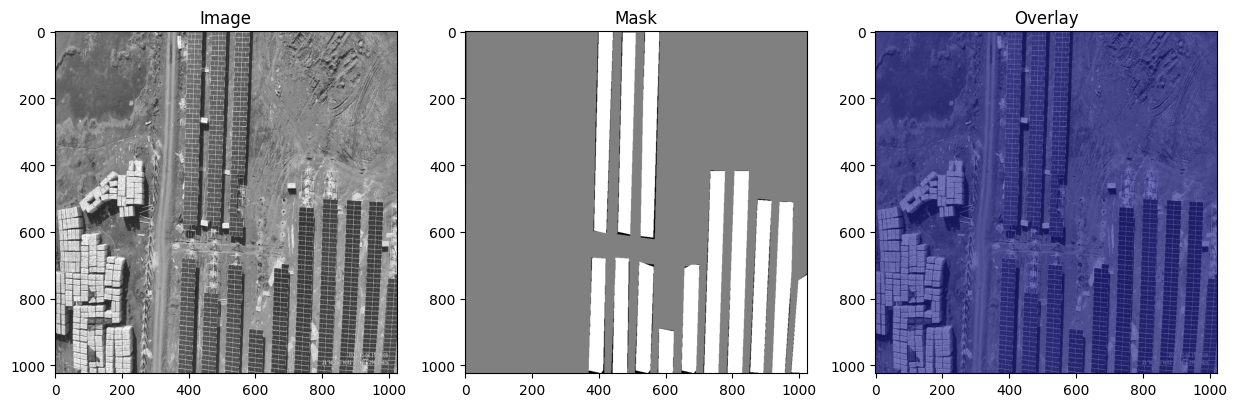

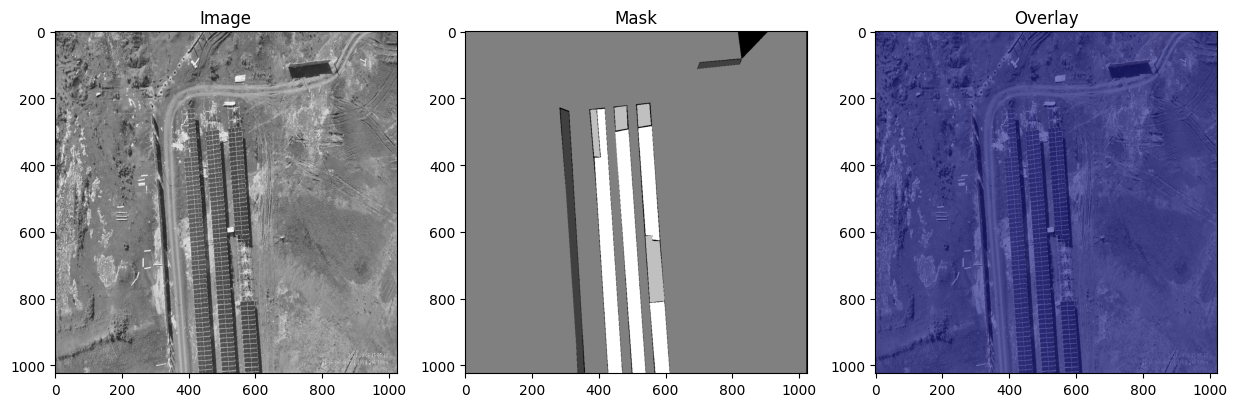

In [8]:
# Check a random subset of image-mask pairs to verify correctness
# Ensure the number of images and masks are equal and their dimensions match
# Visualize the image, mask, and an overlay to check for alignment and quality


# Define how many samples you want to visually inspect
num_samples_to_check = 5  # Checking 5 random samples from the dataset

# Check if the number of images matches the number of masks, to prevent indexing issues
assert len(train_images) == len(train_masks), "Number of images and masks do not match!"

# Randomly pick 'num_samples_to_check' indices to visualize a few image-mask pairs
indices_to_check = random.sample(range(len(train_images)), num_samples_to_check)

# Loop through the selected indices and compare the corresponding image and mask
for idx in indices_to_check:
    img = train_images[idx]  # Fetch the image by index
    mask = train_masks[idx]  # Fetch the corresponding mask by index

    # Ensure that the image and mask have the same dimensions
    assert img.shape == mask.shape, f"Shape mismatch at index {idx}: {img.shape} vs {mask.shape}"

    # Convert the grayscale image to color if needed (helps for visualization purposes)
    if len(img.shape) == 2:  # Check if the image is grayscale (2D)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # Convert grayscale to BGR color

    # Convert the grayscale mask to a color map for better visualization
    if len(mask.shape) == 2:  # Check if the mask is grayscale (2D)
        mask_colored = cv2.applyColorMap(mask, cv2.COLORMAP_JET)  # Apply color map to grayscale mask
    else:
        mask_colored = mask  # If the mask is already colored, use it as is

    # Create an overlay of the mask on top of the image for comparison
    overlay = cv2.addWeighted(img, 0.5, mask_colored, 0.5, 0)  # Blend image and colored mask together

    # Display the original image, mask, and overlay side by side using matplotlib
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper color display in matplotlib
    plt.subplot(1, 3, 2)
    plt.title("Mask")
    plt.imshow(mask, cmap='gray')  # Display the grayscale mask
    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))  # Convert overlay to RGB for display
    plt.show()  # Render the plots


In [9]:
# Flatten the multidimensional mask arrays to apply label encoding
# Convert categorical pixel values to integer labels using LabelEncoder
# Reshape the encoded labels back to the original mask dimensions for further processing


labelencoder = LabelEncoder()

# Capture the shape of the mask array (number of images, height, width)
n, h, w = train_masks.shape  # n: number of masks, h: height, w: width

# Reshape the mask array into a 2D array (flattened) with each pixel label as a row
train_masks_reshaped = train_masks.reshape(-1, 1)  # Flatten the mask array for encoding

# Apply label encoding to the reshaped array (convert categorical labels to integers)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)

# Reshape the encoded labels back into the original mask shape (n, h, w)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
# Print the unique values in the encoded mask array to verify label encoding
# This helps ensure that the encoding process has been applied correctly and check the range of label values


np.unique(train_masks_encoded_original_shape)

array([0, 1, 2, 3, 4])

In [11]:
# Inspect the unique class labels present in the encoded mask array
# Display each unique label and its corresponding class name for verification
# Ensure that all expected classes are correctly represented in the encoded masks


# Retrieve the unique values in the encoded mask array to inspect the class labels
unique_values = np.unique(train_masks_encoded_original_shape)

# Print out each unique value along with its corresponding class name from the category mapping
for val in unique_values:
    print(f"Class {val}: {category_mapping[val]}")  # Display the class label and its mapping

Class 0: Unlabelled
Class 1: Boundary
Class 2: Land
Class 3: Poles
Class 4: Solar_Panels


In [12]:
# Add a channel dimension to the images for compatibility with model input
# Prepare the images for training by ensuring consistent input scaling


# Add an additional dimension to the image array for channel representation
# This step prepares the images for model input, assuming a single channel per image
train_images = np.expand_dims(train_images, axis=3)

# Normalize the pixel values across the images to ensure consistent scaling
# Normalization helps in improving model convergence and performance
train_images = normalize(train_images, axis=1)  # Normalize the images along the specified axis

In [13]:
# Add a channel dimension to the mask array to match the input format required by the model
# This prepares the masks for model training by ensuring they have the correct shape
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [14]:
# Split the dataset into training and testing sets with a 20% test size
# Ensure reproducibility by setting a random seed for the split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size=0.20, random_state=42)

# Print the unique class values present in the training set for verification
# This helps in checking the distribution of classes in the training data
print("Class values in the dataset are ... ", np.unique(y_train)) # 0 is the background/unlabeled

Class values in the dataset are ...  [0 1 2 3 4]


In [15]:
# Convert the training masks into categorical format with one-hot encoding
# This is necessary for models that require categorical cross-entropy loss
train_masks_cat = to_categorical(y_train, num_classes=n_classes)

# Reshape the one-hot encoded masks to match the input shape expected by the model
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

# Convert the test masks into categorical format with one-hot encoding
test_masks_cat = to_categorical(y_test, num_classes=n_classes)

# Reshape the one-hot encoded test masks to the same shape as the training masks
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [16]:
# Extract image dimensions from the training dataset
IMG_HEIGHT = X_train.shape[1]      # Height of the images
IMG_WIDTH = X_train.shape[2]       # Width of the images
IMG_CHANNELS = X_train.shape[3]    # Number of channels in the images

In [17]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    # Define the input layer of the model with specified image dimensions and channels
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path (Encoder)
    # Extract features
    # Downsample the input image
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)  # Add dropout to reduce overfitting
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)  # Pooling to reduce spatial dimensions

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path (Decoder)
    # Upsample
    # Concatenate with corresponding encoder features
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])  # Concatenate with corresponding encoder feature map
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # Output layer with a softmax activation function for multi-class segmentation
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    # Create and return the U-Net model
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [18]:
# Custom Intersection over Union (IoU) Metric Function.
# This function calculates the Intersection over Union (IoU) metric,
# a common evaluation metric for segmentation tasks. The IoU measures the overlap between predicted
# and ground truth values by computing the ratio of their intersection to their union.
# The function flattens the input tensors, rounds predictions to binary format, and calculates the IoU for each class.
# Finally, it returns the mean IoU across all classes to evaluate model performance.


def iou_metric(y_true, y_pred):
    # Flatten the input tensors to make them 1D
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    # Convert the predicted values to binary format by rounding
    y_pred = K.round(y_pred)

    # Compute the intersection of the predicted and true values
    intersection = K.sum(y_true * y_pred, axis=0)

    # Compute the union of the predicted and true values
    union = K.sum(y_true, axis=0) + K.sum(y_pred, axis=0) - intersection

    # Calculate the Intersection over Union (IoU) for each class
    iou = intersection / (union + K.epsilon())  # Adding epsilon to avoid division by zero

    # Return the mean IoU across all classes
    return K.mean(iou)

In [19]:
# Initialize the U-Net model with specified parameters
model = multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

# Compile the model with the Adam optimizer, categorical cross-entropy loss, and custom IoU metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[iou_metric])

# Display the model architecture and summary
model.summary()


# Model Compilation
#   Optimizer: Adam
#   Loss Function: Categorical cross-entropy
#   Metrics: Custom Intersection over Union (IoU) metric

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1024, 1024, 1)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 1024, 1024, 16) │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1024, 1024, 16) │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 1024, 1024, 16) │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 512, 512, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 512, 512, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 512, 512, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 512, 512, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 256, 256, 32)   │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 256, 256, 64)   │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256, 256, 64)   │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 128, 128, 64)   │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128, 128, 128)  │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 64, 64, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 1,940,885 (7.40 MB)

 Trainable params: 1,940,885 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
y_train.shape

(57, 1024, 1024, 1)

In [21]:
# Train the U-Net model with the training data
history = model.fit(X_train, y_train_cat,
                    batch_size=4,                           # Number of samples per gradient update
                    verbose=1,                              # Verbosity mode; 1 = progress bar
                    epochs=50,                              # Number of epochs to train the model
                    validation_data=(X_test, y_test_cat),   # Data to evaluate the model during training
                    shuffle=False)                          # If true shuffle the training data before each epoch

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 145s 6s/step - iou_metric: 0.0656 - loss: 1.4945 - val_iou_metric: 0.0000e+00 - val_loss: 1.1839
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 555ms/step - iou_metric: 0.2108 - loss: 0.9851 - val_iou_metric: 0.7790 - val_loss: 0.5555
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 599ms/step - iou_metric: 0.7758 - loss: 0.5768 - val_iou_metric: 0.7796 - val_loss: 0.4960
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 555ms/step - iou_metric: 0.7771 - loss: 0.5205 - val_iou_metric: 0.7790 - val_loss: 0.4735
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 598ms/step - iou_metric: 0.7764 - loss: 0.5061 - val_iou_metric: 0.7767 - val_loss: 0.4378
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 559ms/step - iou_metric: 0.7740 - loss: 0.4910 - val_iou_metric: 0.7812 - val_loss: 0.4305
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 552ms/step - iou_metric: 0.7723 - loss: 0.4740 - val_iou_metric: 0.7913 - val_loss: 0.3944
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 543ms/step - iou_metric: 0

In [22]:
# Save/Dump the model
model.save('test.hdf5')
model.save('my_model.keras')

In [23]:
# Evaluate the U-Net model on the test data
_, acc = model.evaluate(X_test, y_test_cat)

# Print the accuracy of the model on the test set
print("Accuracy is =", (acc * 100.0), "%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 48s 48s/step - iou_metric: 0.9680 - loss: 0.0509
Accuracy is = 96.7988669872284 %


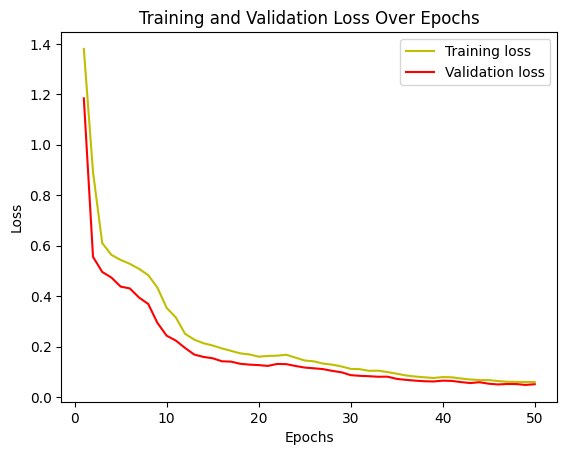

In [24]:
# Extract the loss history from the model training
loss = history.history['loss']
val_loss = history.history['val_loss']

# Define the number of epochs
epochs = range(1, len(loss) + 1)

# Plot the training and validation loss over epochs
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
# Extract the IoU metric history from the model training
acc = history.history['iou_metric']
val_acc = history.history['val_iou_metric']

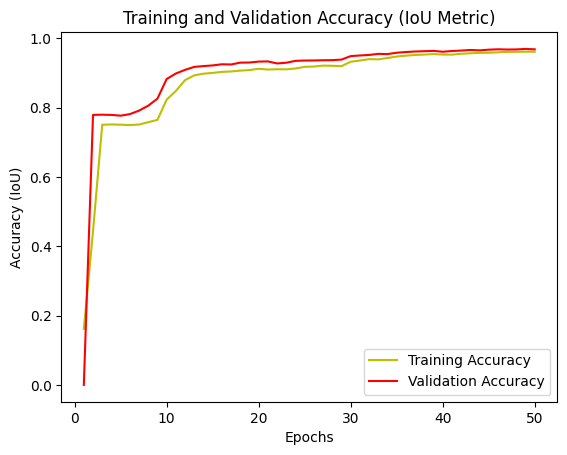

In [26]:
# Plotting Training and Validation Accuracy (IoU Metric)
plt.plot(epochs, acc, 'y', label='Training Accuracy')  # Plot training IoU (referred to as accuracy here)
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')  # Plot validation IoU (referred to as accuracy here)
plt.title('Training and Validation Accuracy (IoU Metric)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (IoU)')
plt.legend()
plt.show()

In [27]:
# The model makes predictions on the test set `X_test`, which outputs probability distributions for each class.
# We extract the most probable class (using `np.argmax`) for each pixel from the predicted probability distributions
# to obtain the final predicted segmentation masks.
# The goal here is to convert the predicted probability maps to class labels,
# facilitating a comparison between the ground truth and predicted masks.


# Predicting Classes for the Test Set
y_pred = model.predict(X_test)  # Model predicts the segmentation masks for the test set

# Converting the Predicted Output to Class Labels
y_pred_argmax = np.argmax(y_pred, axis=3)  # Extract the class with the highest probability for each pixel

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


In [28]:
# Calculate Mean IoU and Class-wise IoU for Test Predictions
# This code calculates the Mean Intersection over Union (IoU) metric, a crucial evaluation metric for segmentation tasks.
# IoU measures the overlap between predicted and ground truth masks across multiple classes.


n_classes = n_classes  # Number of classes in your segmentation task

# Create a MeanIoU metric instance for 'n_classes' categories
IOU_keras = MeanIoU(num_classes=n_classes)

# Update the metric state with the ground truth and predicted masks
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)

# Calculate the overall Mean IoU
mean_iou = IOU_keras.result().numpy()
print("Mean IoU =", mean_iou)

# Extract the confusion matrix
confusion_matrix = IOU_keras.total_cm.numpy()

# Calculate IoU for each class
class_ious = []
for i in range(n_classes):
    intersection = confusion_matrix[i, i]  # True positives for class 'i'
    union = np.sum(confusion_matrix[i, :]) + np.sum(confusion_matrix[:, i]) - intersection  # Union for class 'i'
    iou = intersection / union  # IoU calculation
    class_ious.append(iou)
    print(f"IoU for class '{category_mapping[i]}' is: {iou}")

Mean IoU = 0.5725311
IoU for class 'Unlabelled' is: 0.03245167434215546
IoU for class 'Boundary' is: 0.0
IoU for class 'Land' is: 0.9835307002067566
IoU for class 'Poles' is: 0.9044911861419678
IoU for class 'Solar_Panels' is: 0.9421820640563965


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


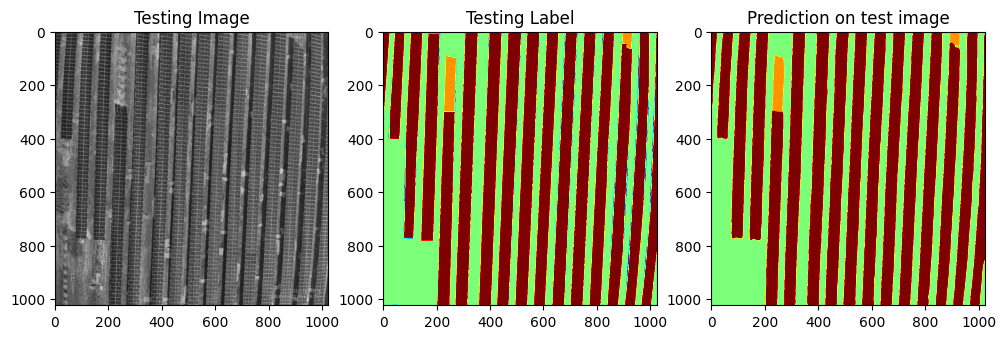

In [29]:
# This is used to visualize the test image, ground truth mask, and the predicted mask
# for a randomly selected test image from the dataset


# Randomly select a test image index
test_img_number = random.randint(0, len(X_test))

# Select the test image and its ground truth mask based on the random index
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]

# Normalize the test image and prepare it for prediction (expand dimensions for model input)
test_img_norm = test_img[:, :, 0][:, :, None]
test_img_input = np.expand_dims(test_img_norm, 0)

# Predict the mask for the test image
prediction = model.predict(test_img_input)

# Convert the predicted probabilities to the predicted class labels
predicted_img = np.argmax(prediction, axis=3)[0, :, :]

# Plot the test image, ground truth mask, and predicted mask side by side
plt.figure(figsize=(12, 8))

# Display the test image
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:, :, 0], cmap='gray')

# Display the ground truth mask
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:, :, 0], cmap='jet')

# Display the predicted mask
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')

# Show the plot
plt.show()

In [31]:
import os
import zipfile

# Define the path to the ZIP file and the extraction directory
zip_file_path = '/content/testing.zip'  # Path to the zip file which include images which are unknown to the model
extract_to = '/content'  # Directory where the files will be extracted

# Ensure the extraction directory exists (create it if it doesn't)
os.makedirs(extract_to, exist_ok=True)

# Extract the ZIP file contents into the extraction directory
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Notify the user that the files have been successfully extracted
print(f"Files extracted to {extract_to}")

Files extracted to /content


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


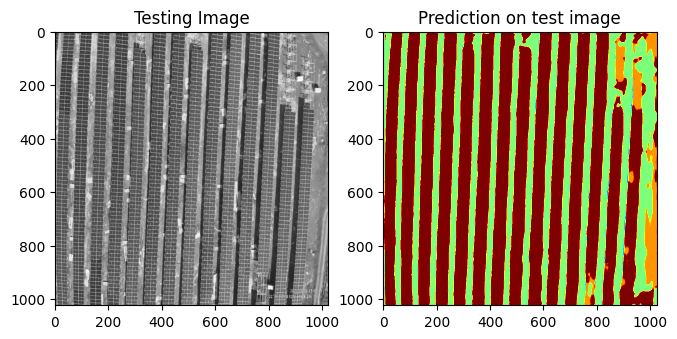

In [42]:
# Load pre-trained model
# model = load_model('test.hdf5')

# Define image path
img_path = "/content/testing/DJI_20231006150544_0037_V.JPG"

# Read the image in grayscale mode (0 for grayscale)
img = cv2.imread(img_path, 0)

# Resize the image to match the input size expected by the model
img = cv2.resize(img, (1024, 1024))

# Normalize pixel values to be between 0 and 1
img = img / 255.0

# Add a channel dimension for grayscale image compatibility (shape becomes 1024x1024x1)
img = np.expand_dims(img, axis=-1)

# Add a batch dimension (shape becomes 1x1024x1024x1, batch size 1)
img = np.expand_dims(img, axis=0)

# Generate prediction from the model
prediction = model.predict(img)

# Extract the predicted class by selecting the class with the highest probability (argmax)
predicted_img = np.argmax(prediction, axis=3)[0, :, :]

# Plot the original grayscale image and the predicted segmentation mask
plt.figure(figsize=(12, 8))

# Display the input grayscale image
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(img[0, :, :, 0], cmap='gray')

# Display the predicted segmentation mask using the jet colormap for better visualization
plt.subplot(232)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')

plt.show()